In [1]:
from pymongo import MongoClient
from sshtunnel import SSHTunnelForwarder
import pprint
from bson.objectid import ObjectId
import pyperclip as clip
import json
import tensorflow as tf
import pandas as pd
import numpy as np
import itertools as it
# from datasu import auc
# import pixiedust
# clip.copy(json.dumps(m1['msg']))


import nbimporter
from nbimporter import NotebookLoader
loader = NotebookLoader()
from common_functions import *
from common_functions_message import *
Message = loader.load_module("common_functions_message").Message

pd.options.mode.chained_assignment = None  # default='warn'


Importing Jupyter notebook from common_functions.ipynb
Importing Jupyter notebook from common_functions_message.ipynb
Importing Jupyter notebook from common_functions_message.ipynb


In [2]:
notebook_name = 'STS1-v2.0'

### funcs

In [3]:
def get_emb_from_cache(text, metadata):   
    q = create_embeddings_cache_query(text,metadata)
    emb_entry = db.embeddings_cache.find_one(q)
    return emb_entry['vector']

def encode_value(value, metadata):
    if isinstance(value,str):
        values = [value]
    else:
        values = value
            
    embs_list = list(map(lambda v: get_emb_from_cache(v,metadata),values))
    return np.array(embs_list)

In [4]:
# def get_metadata(embs, field, index):
#     meta = embs[field][index]
#     dimensions = len(meta['vector'])
#     del meta['vector']     
#     metadata = {            
#         **meta,
#         **{'dimensions': dimensions}
#     }
#     return metadata

### load data

In [5]:
# MONGO_HOST = "ec2-52-23-187-115.compute-1.amazonaws.com"
# MONGO_DB = "marketpulzz"
# server = SSHTunnelForwarder(
#     MONGO_HOST,
#     ssh_username='ubuntu',
#     ssh_pkey="/Users/sasha/.ssh/mmuze.pem",
# #     ssh_private_key_password="secret",
#     remote_bind_address=('127.0.0.1', 27017),
#     local_bind_address=('127.0.0.1', 63327),
#     set_keepalive = 5,
# )

# server.start()
# client = MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
# db = client[MONGO_DB]

In [6]:
MONGO_DB = "marketpulzz"
client = MongoClient('127.0.0.1', 27017)
db = client[MONGO_DB]

In [7]:
# m = db.genie_conversation_messages_emb.find_one({})

# bert_embs_map = {
#     'text': 15
# }

# bert_metadata = get_metadata(m['embs'],'text',bert_embs_map['text'])
# bert_metadata

In [8]:
sample_mt = db.genie_master_tags.find_one({"intents.0":{'$exists':True}})
mess = db.genie_conversation_messages.find_one({"_id": sample_mt['conversation_message_id']})    
fields = list(map(lambda f: f[0], Message(mess).get_fields_for_vector()))
fields

['text',
 'positive_product_type_tags',
 'negative_product_type_tags',
 'positive_aspects',
 'negative_aspects']

In [9]:
# fixed_cat_values = 2
fields_vector_len = {  
 'positive_product_type_tags': 2,
 'negative_product_type_tags': 2,
 'positive_aspects': 2,
 'negative_aspects': 2,
 'text': 1
}
fields_vector_desc = {  
 'positive_product_type_tags': 'emb(2)',
 'negative_product_type_tags': 'emb(2)',
 'positive_aspects': 'emb(2)',
 'negative_aspects': 'emb(2)',
 'text': 'emb(1)'
}

exp_metadata = {    
  'msg_vector_desc': fields_vector_desc,
  'fields': fields
}

In [10]:
def get_message_for_master_tag(mt):   
    mess = db.genie_conversation_messages.find_one({"_id": mt['conversation_message_id']})    
    fields = Message(mess).get_fields_for_vector(fixed_length_by_field=fields_vector_len, fld_name_suffix=None)
    
#     def extr_intent(intent):
#         row = {**{'intent':intent['name'], 'tag':intent['tag']}, **dict(fields)}   
#         retun 
    intents = mt['intents']
    rows = list(map(lambda intent:{**{'intent':intent['name'], 'tag':intent['tag']}, **dict(fields)}, intents))
    return rows
    
master_tags_cursor = db.genie_master_tags.find({"intents.0":{'$exists':True}})
data = list(it.chain(*map(get_message_for_master_tag, master_tags_cursor)))

In [11]:
df_data_all_unfiltered = pd.DataFrame(data)
df_data_all = df_data_all_unfiltered.loc[df_data_all_unfiltered.tag=='true'].copy()
# df_data_all[0:150]['intent'] = 'refund'
# df_data_all[0:150]['text'] = 'I want my money back as soon as possible. Thanks'
df_data_all.head()

,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text
0,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more]
21,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more option]
22,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options]
23,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options please]
26,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[More products]


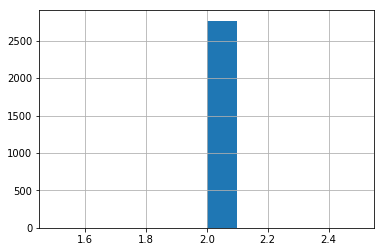

In [12]:
# np.histogram(df_data_all['negative_product_type_tags'].apply(len))
df_data_all_unfiltered['positive_aspects'].apply(len).hist()

### encode data

##### BERT

In [13]:
bert_metadata = {            
    'version': '1.0',
    'encoder': 'BERT',
    'model': 'uncased_L-12_H-768_A-12',    
    'max_seq_len': 200,
    'pooling_strategy': 'REDUCE_MEAN', 
    'pooling_layer': '-5',
    'dimensions':768
}

In [14]:
%%time
bert_embs = df_data_all[fields].applymap(lambda v: encode_value(v,bert_metadata))
df_data_all['emb_bert'] = bert_embs.apply(lambda cols_embs: np.concatenate(cols_embs, axis=None), axis=1)

bert_metadata['dimensions'] = df_data_all['emb_bert'][0].shape[0]

CPU times: user 9.49 s, sys: 683 ms, total: 10.2 s
Wall time: 2min 35s


In [15]:
df_data_all.head()

,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text,emb_bert
0,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more],"[-0.34317147731781006, -0.32750093936920166, -..."
21,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more option],"[-0.045591987669467926, -0.5629469752311707, -..."
22,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options],"[0.11497955769300461, -0.37380194664001465, -0..."
23,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options please],"[0.148829385638237, -0.4163428246974945, 0.112..."
26,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[More products],"[0.10115775465965271, -0.2510954737663269, -0...."


##### USE

In [16]:
use_metadata = {
    'version': '1.0',
    'encoder': 'USE',   
    'model': 'https://tfhub.dev/google/universal-sentence-encoder-large/3',
    'dimensions':512
}

In [17]:
%%time
use_embs = df_data_all[fields].applymap(lambda v: encode_value(v,use_metadata))
df_data_all['emb_use'] = use_embs.apply(lambda cols_embs: np.concatenate(cols_embs, axis=None), axis=1)

use_metadata['dimensions'] = df_data_all['emb_use'][0].shape[0]

CPU times: user 8.95 s, sys: 605 ms, total: 9.55 s
Wall time: 2min 38s


In [18]:
df_data_all.head()

,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text,emb_bert,emb_use
0,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more],"[-0.34317147731781006, -0.32750093936920166, -...","[-0.01044059731066227, -0.036302391439676285, ..."
21,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more option],"[-0.045591987669467926, -0.5629469752311707, -...","[0.009036039933562279, 0.05231931060552597, 0...."
22,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options],"[0.11497955769300461, -0.37380194664001465, -0...","[0.019043365493416786, 0.065824493765831, 0.02..."
23,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options please],"[0.148829385638237, -0.4163428246974945, 0.112...","[0.01806405372917652, 0.0624786913394928, 0.02..."
26,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[More products],"[0.10115775465965271, -0.2510954737663269, -0....","[0.01804543472826481, 0.015222439542412758, 0...."


### evaluation

In [19]:
pipeline = [
{'$unwind': '$intents'},
{'$project' : {'_id': 0, 'intents.name' : 1 , 'intents.category' : 1, 'intents.tag' : 1 } },
{'$group' : {
       '_id' : { 
            'name': "$intents.name", 
            'category': '$intents.category', 
            'tag': '$intents.tag' 
        },
        'name': {'$first': "$intents.name"}, 
        'category': {'$first':'$intents.category'}, 
        'tag': {'$first':'$intents.tag'},      
        'count': { '$sum': 1 }
    }
},
{'$project' : {'_id': 0, 'name' : 1 , 'category' : 1, 'tag' : 1,'count' : 1 }}
]

master_tag_stats = list(db.genie_master_tags.aggregate(pipeline))
df_master_tag_stats = pd.DataFrame(master_tag_stats, columns=['category','name','tag','count'])
df_master_tag_stats.pivot(index='name',values=['count'],columns='tag')

count              
tag                          amb  false   true
name                                          
Add to Wishlist              NaN   18.0    4.0
Back                         NaN   29.0   17.0
Compare                      NaN   24.0    NaN
Complementary                NaN  105.0   63.0
Customer Support             1.0   26.0  631.0
Frustration                  8.0   97.0   13.0
Help                         NaN   48.0   16.0
Introduction                 NaN   17.0    8.0
More                        34.0   32.0   17.0
New Facecare Regimen         NaN  238.0   95.0
Order Information            NaN  116.0  367.0
Product Aspect Information   NaN  122.0   90.0
Product not found            NaN  128.0  396.0
Shop new arrivals            2.0    1.0    4.0

In [20]:
def smooth_intent_prob(w):
    return w*100 if w < 0.01 else w

# print("total count: ",df_data_all.shape[0])
# df_data_agg_by_intent = pd.DataFrame(df_data_all.groupby(['intent']).count()['tag'])
# df_data_agg_by_intent.rename(columns={'tag':'count'}, inplace=True)
# df_data_agg_by_intent['intent_prob'] = df_data_agg_by_intent/df_data_agg_by_intent.sum()
# df_data_agg_by_intent['intent_prob_smoothed'] = df_data_agg_by_intent['intent_prob'].apply(smooth_intent_prob)
# df_data_agg_by_intent

#calc intent pro
df_data_all['intent_prob'] = 1.0#df_data_all.groupby(['intent']).transform('count')['text']/df_data_all.shape[0]
# df_data_all['intent_prob_weighted'] = df_data_all.groupby(['intent']).transform('count')['text']/df_data_all.shape[0]
# df_data_all['intent_prob_smoothed'] = df_data_all['intent_prob'].apply(smooth_intent_prob)
print("max message length: ", df_data_all['text'].map(len).max())
df_data_all.head(n=5)

max message length:  1


,intent,negative_aspects,negative_product_type_tags,positive_aspects,positive_product_type_tags,tag,text,emb_bert,emb_use,intent_prob
0,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more],"[-0.34317147731781006, -0.32750093936920166, -...","[-0.01044059731066227, -0.036302391439676285, ...",1.0
21,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more option],"[-0.045591987669467926, -0.5629469752311707, -...","[0.009036039933562279, 0.05231931060552597, 0....",1.0
22,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options],"[0.11497955769300461, -0.37380194664001465, -0...","[0.019043365493416786, 0.065824493765831, 0.02...",1.0
23,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[more options please],"[0.148829385638237, -0.4163428246974945, 0.112...","[0.01806405372917652, 0.0624786913394928, 0.02...",1.0
26,More,"[*, *]","[*, *]","[*, *]","[*, *]",true,[More products],"[0.10115775465965271, -0.2510954737663269, -0....","[0.01804543472826481, 0.015222439542412758, 0....",1.0


In [26]:
N = 300
df_query = df_data_all.sample(n=N, weights='intent_prob',random_state=888)
# df_query = df_data_all.sample(n=N, weights='intent_prob',random_state=108)
df_query
df_data = df_data_all.drop(df_query.index)

df_query_stats = pd.DataFrame()
df_query_stats['data'] = df_data.groupby(['intent']).count()['text']
df_query_stats['query'] = df_query.groupby(['intent']).count()['text']
df_query_stats['query_TP'] = df_query_stats['query']*df_query_stats['data']
df_query_stats['Q/D ratio'] = round(df_query_stats['query']/df_query_stats['data'],3)

data_metadata = {
    'intents': df_query_stats.index.values.tolist(),
    'data_query_stats':df_query_stats.to_dict()
}

print(df_query_stats)
print("")
print(f"total: {len(df_data_all)} => query:{len(df_query)} + data:{len(df_data)}")
total_rows = len(df_query)*len(df_data)
total_TP = df_query_stats['query_TP'].sum()
print(f"total rows:{total_rows} => total TP:{total_TP} TP_ratio:{round(df_query_stats['query_TP'].sum()/total_rows, 2)}")

                            data  query  query_TP  Q/D ratio
intent                                                      
Add to Wishlist                3      1         3      0.333
Back                          16      1        16      0.062
Complementary                 54      9       486      0.167
Customer Support             522    109     56898      0.209
Frustration                   11      2        22      0.182
Help                          13      3        39      0.231
Introduction                   5      3        15      0.600
More                          14      3        42      0.214
New Facecare Regimen          75     20      1500      0.267
Order Information            296     71     21016      0.240
Product Aspect Information    79     11       869      0.139
Product not found            330     66     21780      0.200
Shop new arrivals              3      1         3      0.333

total: 1721 => query:300 + data:1421
total rows:426300 => total TP:102689 TP_ratio:0

In [22]:
df_eval = df_crossjoin(df_query[['emb_bert', 'emb_use', 'intent']], df_data, suffixes=('_q', ''))
# df_eval = df_crossjoin(df_query[['emb_use', 'intent']], df_data, suffixes=('_q', ''))
# df_eval = df_crossjoin(df_query[['emb_bert', 'intent']], df_data, suffixes=('_q', ''))

df_eval['is_same_intent'] = (df_eval['intent_q'] == df_eval['intent']).values
print("total rows: ",df_eval.shape[0])
df_eval.head(n=5)

total rows:  426300


emb_bert_q  \
2188 0   [-0.043738238513469696, 0.08234232664108276, 0...   
     21  [-0.043738238513469696, 0.08234232664108276, 0...   
     26  [-0.043738238513469696, 0.08234232664108276, 0...   
     27  [-0.043738238513469696, 0.08234232664108276, 0...   
     33  [-0.043738238513469696, 0.08234232664108276, 0...   

                                                 emb_use_q          intent_q  \
2188 0   [-0.05212119221687317, -0.009759193286299706, ...  Customer Support   
     21  [-0.05212119221687317, -0.009759193286299706, ...  Customer Support   
     26  [-0.05212119221687317, -0.009759193286299706, ...  Customer Support   
     27  [-0.05212119221687317, -0.009759193286299706, ...  Customer Support   
     33  [-0.05212119221687317, -0.009759193286299706, ...  Customer Support   

        intent negative_aspects negative_product_type_tags positive_aspects  \
2188 0    More           [*, *]                     [*, *]           [*, *]   
     21   More           [*, *]                     [*, *]           [*, *]   
     26   More           [*, *]                     [*, *]           [*, *]   
     27   More           [*, *]                     [*, *]           [*, *]   
     33   More           [*, *]                     [*, *]           [*, *]   

        positive_product_type_tags   tag                    text  \
2188 0                      [*, *]  true                  [more]   
     21                     [*, *]  true           [more option]   
     26                     [*, *]  true         [More products]   
     27                     [*, *]  true  [More products please]   
     33                     [*, *]  true                  [next]   

                                                  emb_bert  \
2188 0   [-0.34317147731781006, -0.32750093936920166, -...   
     21  [-0.045591987669467926, -0.5629469752311707, -...   
     26  [0.10115775465965271, -0.2510954737663269, -0....   
     27  [0.2176562249660492, -0.33121806383132935, 0.0...   
     33  [-0.42166009545326233, -0.34050989151000977, -...   

                                                   emb_use  intent_prob  \
2188 0   [-0.01044059731066227, -0.036302391439676285, ...          1.0   
     21  [0.009036039933562279, 0.05231931060552597, 0....          1.0   
     26  [0.01804543472826481, 0.015222439542412758, 0....          1.0   
     27  [-0.0006539868772961199, -0.03015582635998726,...          1.0   
     33  [0.038845062255859375, -0.035450711846351624, ...          1.0   

         is_same_intent  
2188 0            False  
     21           False  
     26           False  
     27           False  
     33           False

In [23]:
ev_results = []
def add_ev_res(res, encoder, emb_metadata, exp_metadata, data_metadata):  
    metric = [{'name':k, 'value':v} for k,v in res.items()][0]
    ev_res = {
        'notebook': notebook_name,
        'encoder':encoder,
        'emb_metadata': emb_metadata, 
        'exp_metadata':exp_metadata,
        'metric': metric,
        'data_metadata': data_metadata
    }    
    
#     ev_res = {**exp, **res}    
    ev_results.append(ev_res)

In [24]:
# import sys

# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# sorted([(x, sys.getsizeof(globals().get(x))/10**9) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

In [25]:
def metric_at_K(metric_func, df_eval, column_name, K):
    df_eval.sort_values(by=[column_name], ascending=False)[0:K]
    metric_K = metric_func(df_eval[column_name].values, df_eval['is_same_intent'].values, False)
    return metric_K

#### evaluate BERT

In [27]:
%%time
def calc_dist_use(df):
    emb_query_arr = np.stack(df['emb_bert_q'].values)
    emb_data_arr = np.stack(df['emb_bert'].values)
    angdist, cossim = sim_exact(emb_query_arr, emb_data_arr)
    df['angdist_bert'] = angdist#.diagonal()
    df['cossim_bert'] = cossim#.diagonal()    
    return df

df_eval = apply_by_chunks(df_eval, 30000, calc_dist_use)
df_eval_by_angdist_bert = df_eval.sort_values(by=['angdist_bert'], ascending=False)[0:total_TP]
df_eval_by_angdist_bert.head()

CPU times: user 2min 28s, sys: 2min 27s, total: 4min 56s
Wall time: 1min 47s


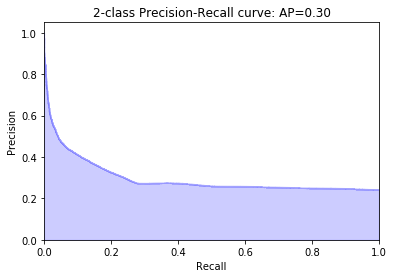

In [28]:
MAP_DQ_bert = plot_precision_recall_curve(df_eval['angdist_bert'].values, df_eval['is_same_intent'].values)
add_ev_res({'MAP_DQ':MAP_DQ_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)

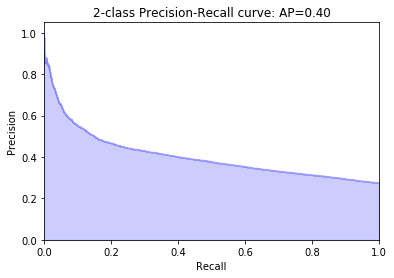

In [29]:
MAP_TP_bert = plot_precision_recall_curve(df_eval_by_angdist_bert['angdist_bert'].values, df_eval_by_angdist_bert['is_same_intent'].values)
add_ev_res({'MAP_TP':MAP_TP_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)   

In [30]:
MAP_K15_bert = df_eval.groupby('intent_q').apply(lambda df_eval_intent: metric_at_K(plot_precision_recall_curve, df_eval_intent, 'angdist_bert', 15)).mean();
add_ev_res({'MAP_K15':MAP_K15_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)

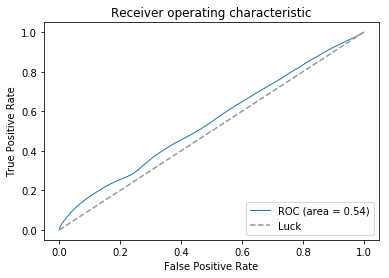

In [31]:
AUC_DQ_bert = plot_auc_curve(df_eval['angdist_bert'].values, df_eval['is_same_intent'].values)
add_ev_res({'AUC_DQ':AUC_DQ_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)   

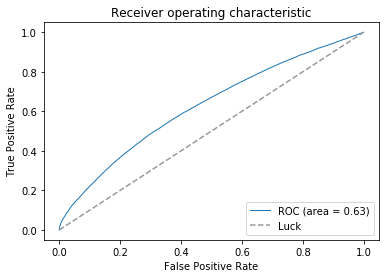

In [32]:
AUC_TP_bert = plot_auc_curve(df_eval_by_angdist_bert['angdist_bert'].values, df_eval_by_angdist_bert['is_same_intent'].values)
add_ev_res({'AUC_TP':AUC_TP_bert}, 'bert', bert_metadata, exp_metadata, data_metadata) 

In [33]:
AUC_K15_bert = df_eval.groupby('intent_q').apply(lambda df_eval_intent: metric_at_K(plot_auc_curve, df_eval_intent, 'angdist_bert', 15)).mean();
add_ev_res({'AUC_K15':AUC_K15_bert}, 'bert', bert_metadata, exp_metadata, data_metadata)

#### evaluate USE

In [34]:
%%time
def calc_dist_use(df):
    emb_query_arr = np.stack(df['emb_use_q'].values)
    emb_data_arr = np.stack(df['emb_use'].values)
    angdist, cossim = sim_exact(emb_query_arr, emb_data_arr)
    df['angdist_use'] = angdist#.diagonal()
    df['cossim_use'] = cossim#.diagonal()    
    return df

df_eval = apply_by_chunks(df_eval, 30000, calc_dist_use)
df_eval_res_by_angdist_use = df_eval.sort_values(by=['angdist_use'], ascending=False)[0:total_TP]

CPU times: user 1min 36s, sys: 1min 18s, total: 2min 55s
Wall time: 55 s


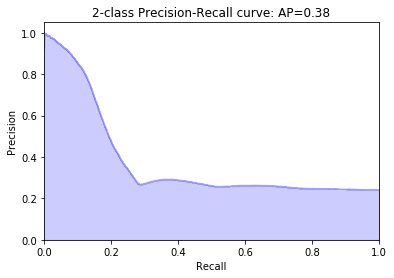

In [35]:
MAP_DQ_use = plot_precision_recall_curve(df_eval['angdist_use'].values, df_eval['is_same_intent'].values)
add_ev_res({'MAP_DQ':MAP_DQ_use}, 'use', use_metadata, exp_metadata, data_metadata)   

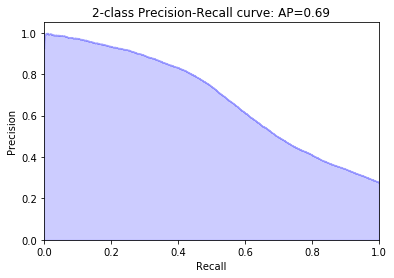

In [36]:
MAP_TP_use = plot_precision_recall_curve(df_eval_res_by_angdist_use['angdist_use'].values, df_eval_res_by_angdist_use['is_same_intent'].values)
add_ev_res({'MAP_TP':MAP_TP_use}, 'use', use_metadata, exp_metadata, data_metadata)   

In [37]:
MAP_K15_use = df_eval.groupby('intent_q').apply(lambda df_eval_intent: metric_at_K(plot_precision_recall_curve, df_eval_intent, 'angdist_use', 15)).mean();
add_ev_res({'MAP_K15':MAP_K15_use}, 'use', use_metadata, exp_metadata, data_metadata)

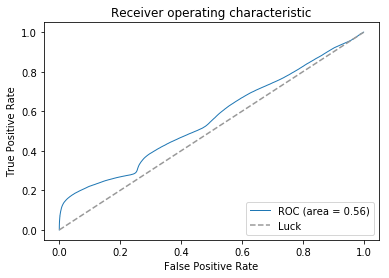

In [38]:
AUC_DQ_use = plot_auc_curve(df_eval['angdist_use'].values, df_eval['is_same_intent'].values)
add_ev_res({'AUC_DQ':AUC_DQ_use}, 'use', use_metadata, exp_metadata, data_metadata)  

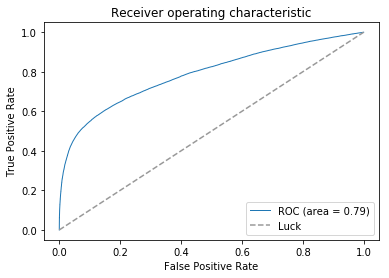

In [39]:
AUC_TP_use = plot_auc_curve(df_eval_res_by_angdist_use['angdist_use'].values, df_eval_res_by_angdist_use['is_same_intent'].values)
add_ev_res({'AUC_TP':AUC_TP_use}, 'use', use_metadata, exp_metadata, data_metadata)   

In [40]:
AUC_K15_use = df_eval.groupby('intent_q').apply(lambda df_eval_intent: metric_at_K(plot_auc_curve, df_eval_intent, 'angdist_use', 15)).mean();
add_ev_res({'AUC_K15':AUC_K15_use}, 'use', use_metadata, exp_metadata, data_metadata)

#### save results

In [41]:
ev_results[0]

{'notebook': 'STS1-v2.0',
 'encoder': 'bert',
 'emb_metadata': {'version': '1.0',
  'encoder': 'BERT',
  'model': 'uncased_L-12_H-768_A-12',
  'max_seq_len': 200,
  'pooling_strategy': 'REDUCE_MEAN',
  'pooling_layer': '-5',
  'dimensions': 6912},
 'exp_metadata': {'msg_vector_desc': {'positive_product_type_tags': 'emb(2)',
   'negative_product_type_tags': 'emb(2)',
   'positive_aspects': 'emb(2)',
   'negative_aspects': 'emb(2)',
   'text': 'emb(1)'},
  'fields': ['text',
   'positive_product_type_tags',
   'negative_product_type_tags',
   'positive_aspects',
   'negative_aspects']},
 'metric': {'name': 'MAP_DQ', 'value': 0.2976473775037819},
 'data_metadata': {'intents': ['Add to Wishlist',
   'Back',
   'Complementary',
   'Customer Support',
   'Frustration',
   'Help',
   'Introduction',
   'More',
   'New Facecare Regimen',
   'Order Information',
   'Product Aspect Information',
   'Product not found',
   'Shop new arrivals'],
  'data_query_stats': {'data': {'Add to Wishlist': 3

In [42]:
db.sts1_bert_use.insert_many(ev_results)